In [49]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 100 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client

In [51]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'tseries'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'salt'
year      = [1958, 2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
box_region = list()
box_region.append('global')
# box_region.append('ocean_basins/Arctic_Basin.shp')
# box_region.append('ocean_basins/Eurasian_Basin.shp')
# box_region.append('mpas_region/Canada_Basin.shp')
# box_region.append('mpas_region/North_Atlantic_Ocean.shp')
# box_region.append('mpas_region/Greenland_Sea.shp')
# box_region.append('mpas_region/Irminger_Sea.shp')
# box_region.append('mpas_region/Norwegian_Sea.shp')
# box_region.append('mpas_region/Labrador_Sea.shp')
# box_region.append('mpas_region/North_Pacific_Ocean.shp')
# box_region.append('mpas_region/South_Pacific_Ocean.shp')
# box_region.append('mpas_region/Southern_Ocean.shp')
# box_region.append('mpas_region/Western_Weddell_Sea.shp')

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = None
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 3 
which_dpi = 300
do_rescale= None
do_allcycl= False
do_concat = False
which_tmean= 'None'
which_hzmean= 'wmean'

In [52]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl is not "None"): 
    #__________________________________________________________________________________________________
    if do_allcycl: cycl_s=1
    else         : cycl_s=which_cycl    
    
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, which_cycl+1):
            # input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if (ref_path is not None) and (ref_path is not "None"): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, which_cycl+1):
            #ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
    
#______________________________________________________________________________________________________
# in case of diff plots
if (ref_path is not None) and (ref_path is not "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None) and (ref_path is not "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names        
        
#______________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_region:
    if region is 'global' or isinstance(region,list): box.append(region)
    else: 
        print(tpv.__path__[0],region)
        box.append(shp.Reader(os.path.join(shp_path,region)))    

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [57]:
#___LOAD FESOM2 DATA___________________________________________________________________________________
list_tseries  = list()
for datapath, descript in zip(input_paths, input_names):
    #__________________________________________________________________________________________________
    # load data and do vertical weighted mean 
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, descript=descript, 
                                do_tarithm='None', do_zarithm='None', do_zweight=True, do_info=False)
    
    #__________________________________________________________________________________________________
    # select horizontal index region --> do horizontal weighted mean 
    data = tpv.load_index_fesom2(mesh, data, box, do_harithm=which_hzmean, do_zarithm=which_hzmean)
    
    #__________________________________________________________________________________________________
    # compute year mean
    if   which_tmean=='annual':
        data[0] = data[0].groupby('time.year').mean('time', keep_attrs=True)
    # compute month mon --> seasonal cycle     
    elif which_tmean=='monthly':
        data[0] = data[0].groupby('time.month').mean('time', keep_attrs=True)
    list_tseries.append(data)
    del(data)


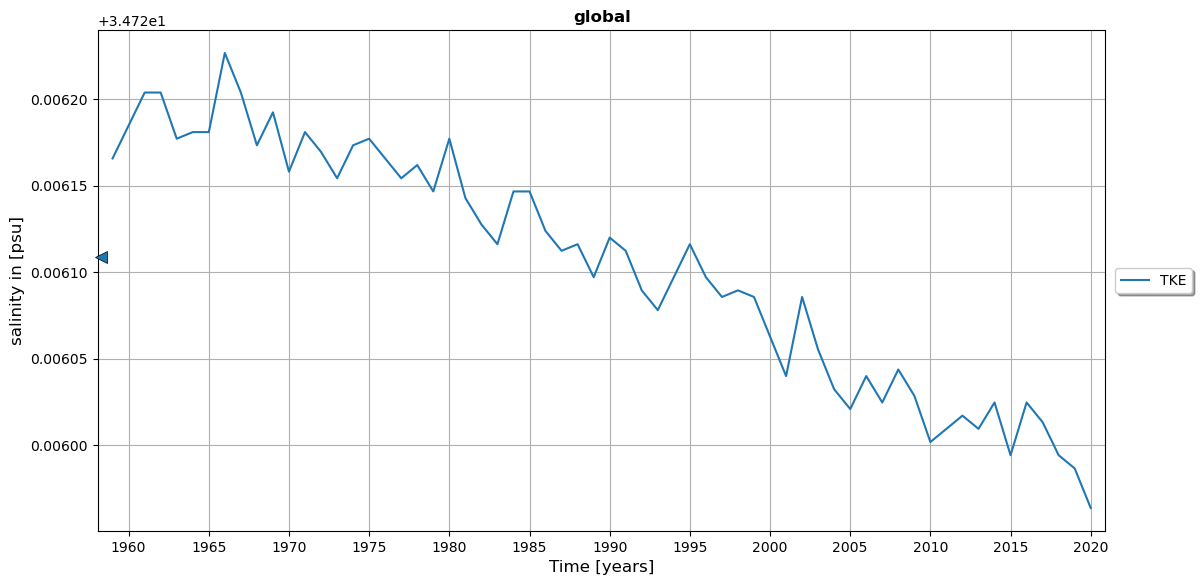

In [56]:
#___PLOT FESOM2 TIME SERIES___________________________________________________________________________________
# save_path ='./'
spath    = save_path
sname    = list(list_tseries[0][0].keys())[0]
slabel   = list_tseries[0][0][sname].attrs['str_lsave']
boxname  = list_tseries[0][0][sname].attrs['boxname']
sboxname = boxname.replace(' ','_')
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}_{}.png'.format(which_mode, sname, sboxname, slabel)) 
if save_fname is not None: spath = save_fname
    
fig,ax=tpv.plot_tseries(list_tseries, input_names, boxname,  
                              which_cycl=which_cycl, do_allcycl=do_allcycl, do_concat=do_concat, 
                              do_save=spath, save_dpi=which_dpi, )  